### Import

In [90]:
import re
import pandas as pd
from datetime import datetime
from web3 import Web3
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import seaborn as sns

gnosis_rpc_url = 'https://lb.nodies.app/v1/406d8dcc043f4cb3959ed7d6673d311a'
web3 = Web3(Web3.HTTPProvider(gnosis_rpc_url))

In [91]:
import warnings
warnings.filterwarnings('ignore')

# 4 significant digits
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Preparation

In [92]:
tools = pd.read_csv('../tools.csv')
fpmms = pd.read_csv('../fpmms.csv')
summary_traders = pd.read_csv('../summary_profitability.csv')
all_trades = pd.read_csv('../all_trades_profitability.csv')

##### Add request block timestamp

In [4]:
def block_number_to_timestamp(block_number):
    block = web3.eth.get_block(block_number)
    timestamp = datetime.utcfromtimestamp(block['timestamp'])
    return timestamp.strftime('%Y-%m-%d %H:%M:%S')

def parallelize_timestamp_conversion(df, function):
    block_numbers = df['request_block'].tolist()
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(tqdm(executor.map(function, block_numbers), total=len(block_numbers)))    
    return results

tools['request_time'] = parallelize_timestamp_conversion(tools, block_number_to_timestamp)

100%|██████████| 227082/227082 [23:21<00:00, 162.01it/s]


In [5]:
# month-year
tools['request_month_year'] = pd.to_datetime(tools['request_time']).dt.strftime('%Y-%m')
# get week number by month-year
tools['request_month_year_week'] = pd.to_datetime(tools['request_time']).dt.strftime('%Y-%m-%U')

##### Add title and currentAnswer from fpmms

In [6]:
def get_question(text):
    # Regex to find text within double quotes
    pattern = r'"([^"]*)"'

    # Find all occurrences
    questions = re.findall(pattern, text)

    # Assuming you want the first question if there are multiple
    question = questions[0] if questions else None

    return question

tools['title'] = tools['prompt_request'].apply(lambda x: get_question(x))

In [7]:
def current_answer(text):
    row = fpmms[fpmms['title'] == text]
    if row.shape[0] == 0:
        return None
    return row['currentAnswer'].values[0]

tools['currentAnswer'] = tools['title'].apply(lambda x: current_answer(x))

In [8]:
# tools.to_csv('../tools.csv', index=False)

### Error analysis

Error analysis only starts from block 321. We weren't capturing the error message prior

In [93]:
inc_tools = [
    'prediction-online', 
    'prediction-offline', 
    'normal-sme-generator',
    'claude-prediction-offline', 
    'prediction-offline-sme',
    'claude-prediction-online', 
    'prediction-online-sme',
    'prediction-request-rag'
]

In [94]:
tools_inc = tools[tools['tool'].isin(inc_tools)]
tools_inc['error'] = tools_inc['error_message'].notnull()

In [95]:
error = tools_inc.groupby(['tool', 'request_month_year_week', 'error']).size().unstack().fillna(0).reset_index()
error['error_perc'] = (error[True] / (error[False] + error[True]))*100
error['total_requests'] = error[False] + error[True]

In [96]:
# clude-prediction-offline
claude_prediction_offline = error[error['tool'] == 'claude-prediction-offline']
claude_prediction_offline = claude_prediction_offline.sort_values('request_month_year_week')
claude_prediction_offline

error,tool,request_month_year_week,False,True,error_perc,total_requests
0,claude-prediction-offline,2023-09-39,371.000,128.000,25.651,499.000
1,claude-prediction-offline,2023-10-40,636.000,327.000,33.956,963.000
2,claude-prediction-offline,2023-10-41,576.000,380.000,39.749,956.000
3,claude-prediction-offline,2023-10-42,1147.000,327.000,22.185,1474.000
4,claude-prediction-offline,2023-10-43,580.000,174.000,23.077,754.000
5,claude-prediction-offline,2023-10-44,82.000,32.000,28.070,114.000
6,claude-prediction-offline,2023-11-44,49.000,13.000,20.968,62.000
7,claude-prediction-offline,2023-11-45,1.000,0.000,0.000,1.000
8,claude-prediction-offline,2023-11-46,4.000,0.000,0.000,4.000
9,claude-prediction-offline,2023-11-47,2.000,16.000,88.889,18.000


In [97]:
# claude-prediction-online
claude_prediction_online = error[error['tool'] == 'claude-prediction-online']
claude_prediction_online = claude_prediction_online.sort_values('request_month_year_week')
claude_prediction_online


error,tool,request_month_year_week,False,True,error_perc,total_requests
12,claude-prediction-online,2023-09-39,159.000,536.000,77.122,695.000
13,claude-prediction-online,2023-10-40,201.000,884.000,81.475,1085.000
14,claude-prediction-online,2023-10-41,553.000,1498.000,73.038,2051.000
15,claude-prediction-online,2023-10-42,609.000,844.000,58.087,1453.000
16,claude-prediction-online,2023-10-43,85.000,129.000,60.280,214.000
17,claude-prediction-online,2023-10-44,38.000,46.000,54.762,84.000
18,claude-prediction-online,2023-11-44,16.000,10.000,38.462,26.000
19,claude-prediction-online,2023-11-46,0.000,4.000,100.000,4.000
20,claude-prediction-online,2023-11-47,1.000,18.000,94.737,19.000
21,claude-prediction-online,2023-11-48,5.000,40.000,88.889,45.000


In [98]:
# prediction-offline
prediction_offline = error[error['tool'] == 'prediction-offline']
prediction_offline = prediction_offline.sort_values('request_month_year_week')
prediction_offline


error,tool,request_month_year_week,False,True,error_perc,total_requests
43,prediction-offline,2023-07-28,1.000,2.000,66.667,3.000
44,prediction-offline,2023-08-31,69.000,0.000,0.000,69.000
45,prediction-offline,2023-08-32,4.000,0.000,0.000,4.000
46,prediction-offline,2023-08-35,3.000,0.000,0.000,3.000
47,prediction-offline,2023-09-35,1.000,0.000,0.000,1.000
48,prediction-offline,2023-09-36,3.000,0.000,0.000,3.000
49,prediction-offline,2023-09-37,10.000,0.000,0.000,10.000
50,prediction-offline,2023-09-38,266.000,4.000,1.481,270.000
51,prediction-offline,2023-09-39,538.000,2.000,0.370,540.000
52,prediction-offline,2023-10-40,1047.000,9.000,0.852,1056.000


In [99]:
# prediction-online
prediction_online = error[error['tool'] == 'prediction-online']
prediction_online = prediction_online.sort_values('request_month_year_week')
prediction_online


error,tool,request_month_year_week,False,True,error_perc,total_requests
76,prediction-online,2023-07-28,12.000,29.000,70.732,41.000
77,prediction-online,2023-07-29,56.000,0.000,0.000,56.000
78,prediction-online,2023-07-30,35.000,4.000,10.256,39.000
79,prediction-online,2023-07-31,93.000,73.000,43.976,166.000
80,prediction-online,2023-08-31,565.000,131.000,18.822,696.000
81,prediction-online,2023-08-32,312.000,11.000,3.406,323.000
82,prediction-online,2023-08-33,889.000,84.000,8.633,973.000
83,prediction-online,2023-08-34,1618.000,172.000,9.609,1790.000
84,prediction-online,2023-08-35,1733.000,11.000,0.631,1744.000
85,prediction-online,2023-09-35,576.000,5.000,0.861,581.000


In [100]:
# prediction-offline-sme
prediction_offline_sme = error[error['tool'] == 'prediction-offline-sme']
prediction_offline_sme = prediction_offline_sme.sort_values('request_month_year_week')
prediction_offline_sme

error,tool,request_month_year_week,False,True,error_perc,total_requests
64,prediction-offline-sme,2023-09-39,488.000,3.000,0.611,491.000
65,prediction-offline-sme,2023-10-40,983.000,11.000,1.107,994.000
66,prediction-offline-sme,2023-10-41,872.000,3.000,0.343,875.000
67,prediction-offline-sme,2023-10-42,736.000,41.000,5.277,777.000
68,prediction-offline-sme,2023-10-43,800.000,63.000,7.300,863.000
69,prediction-offline-sme,2023-10-44,322.000,3.000,0.923,325.000
70,prediction-offline-sme,2023-11-44,185.000,0.000,0.000,185.000
71,prediction-offline-sme,2023-11-46,9.000,0.000,0.000,9.000
72,prediction-offline-sme,2023-11-47,18.000,0.000,0.000,18.000
73,prediction-offline-sme,2023-11-48,18.000,0.000,0.000,18.000


In [101]:
# prediction-online-sme
prediction_online_sme = error[error['tool'] == 'prediction-online-sme']
prediction_online_sme = prediction_online_sme.sort_values('request_month_year_week')
prediction_online_sme

error,tool,request_month_year_week,False,True,error_perc,total_requests
108,prediction-online-sme,2023-09-38,94.000,2.000,2.083,96.000
109,prediction-online-sme,2023-09-39,545.000,23.000,4.049,568.000
110,prediction-online-sme,2023-10-40,1096.000,23.000,2.055,1119.000
111,prediction-online-sme,2023-10-41,870.000,10.000,1.136,880.000
112,prediction-online-sme,2023-10-42,592.000,22.000,3.583,614.000
113,prediction-online-sme,2023-10-43,472.000,21.000,4.260,493.000
114,prediction-online-sme,2023-10-44,76.000,1.000,1.299,77.000
115,prediction-online-sme,2023-11-44,209.000,4.000,1.878,213.000
116,prediction-online-sme,2023-11-45,1421.000,159.000,10.063,1580.000
117,prediction-online-sme,2023-11-46,2212.000,23.000,1.029,2235.000


In [102]:
# prediction-request-rag
prediction_request_rag = error[error['tool'] == 'prediction-request-rag']
prediction_request_rag = prediction_request_rag.sort_values('request_month_year_week')
prediction_request_rag

error,tool,request_month_year_week,False,True,error_perc,total_requests
139,prediction-request-rag,2024-02-08,52.000,26.000,33.333,78.000
140,prediction-request-rag,2024-03-08,255.000,165.000,39.286,420.000
141,prediction-request-rag,2024-03-09,6741.000,249.000,3.562,6990.000
142,prediction-request-rag,2024-03-10,3590.000,265.000,6.874,3855.000


### Win analysis

In [103]:
# only include non error requests
tools_non_error = tools_inc[tools_inc['error'] != True]
tools_non_error['currentAnswer'].replace('no', 'No', inplace=True)
tools_non_error = tools_non_error[tools_non_error['currentAnswer'].isin(['Yes', 'No'])]
tools_non_error = tools_non_error[tools_non_error['vote'].isin(['Yes', 'No'])]

In [104]:
tools_non_error['win'] = tools_non_error['currentAnswer'] == tools_non_error['vote']
tools_non_error['win'] = tools_non_error['win'].astype(int)

In [105]:
wins = tools_non_error.groupby(['tool', 'request_month_year_week', 'win']).size().unstack().fillna(0)
wins['win_perc'] = (wins[1] / (wins[0] + wins[1]))*100
wins.reset_index(inplace=True)
wins['total_request'] = wins[0] + wins[1]

In [106]:
wins['tool'].unique()

array(['claude-prediction-offline', 'claude-prediction-online',
       'prediction-offline', 'prediction-offline-sme',
       'prediction-online', 'prediction-online-sme',
       'prediction-request-rag'], dtype=object)

In [151]:
wins.groupby('request_month_year_week').agg({
    0: 'sum',
    1: 'sum',
    'win_perc': 'mean',
    'total_request': 'sum'
})

win,0,1,win_perc,total_request
request_month_year_week,,,,
2023-07-29,1.000,1.000,50.000,2.000
2023-07-30,9.000,9.000,50.000,18.000
2023-07-31,43.000,35.000,44.872,78.000
2023-08-31,320.000,197.000,41.510,517.000
2023-08-32,185.000,115.000,44.128,300.000
2023-08-33,398.000,428.000,51.816,826.000
2023-08-34,943.000,580.000,38.083,1523.000
2023-08-35,889.000,756.000,45.957,1645.000
2023-09-35,375.000,150.000,28.571,525.000


In [107]:
# select only claude-prediction-online and plot request_month_year_week vs win_perc
claude_prediction_online = wins[wins['tool'] == 'claude-prediction-online']
claude_prediction_online = claude_prediction_online[['request_month_year_week', 'win_perc', 'total_request']]
claude_prediction_online = claude_prediction_online.sort_values(by='request_month_year_week')


claude_prediction_online

win,request_month_year_week,win_perc,total_request
10,2023-09-39,58.696,46.000
11,2023-10-40,62.585,147.000
12,2023-10-41,59.381,517.000
13,2023-10-42,60.746,563.000
14,2023-10-43,44.595,74.000
15,2023-10-44,60.606,33.000
16,2023-11-44,66.667,15.000
17,2023-11-47,100.000,1.000
18,2023-11-48,66.667,3.000
19,2023-12-48,66.667,3.000


In [108]:
# select only claude-prediction-offline and plot request_month_year_week vs win_perc
claude_prediction_offline = wins[wins['tool'] == 'claude-prediction-offline']
claude_prediction_offline = claude_prediction_offline[['request_month_year_week', 'win_perc', 'total_request']]
claude_prediction_offline = claude_prediction_offline.sort_values(by='request_month_year_week')

claude_prediction_offline

win,request_month_year_week,win_perc,total_request
0,2023-09-39,51.572,159.000
1,2023-10-40,53.532,269.000
2,2023-10-41,56.508,315.000
3,2023-10-42,57.692,676.000
4,2023-10-43,56.316,380.000
5,2023-10-44,55.556,54.000
6,2023-11-44,90.323,31.000
7,2023-11-45,100.000,1.000
8,2023-11-46,100.000,2.000
9,2023-12-51,20.000,5.000


In [109]:
# select only prediction-online and plot request_month_year_week vs win_perc
prediction_online = wins[wins['tool'] == 'prediction-online']
prediction_online = prediction_online[['request_month_year_week', 'win_perc', 'total_request']]
prediction_online = prediction_online.sort_values(by='request_month_year_week')

prediction_online

win,request_month_year_week,win_perc,total_request
61,2023-07-29,50.000,2.000
62,2023-07-30,50.000,18.000
63,2023-07-31,44.872,78.000
64,2023-08-31,37.367,471.000
65,2023-08-32,38.255,298.000
66,2023-08-33,51.816,826.000
67,2023-08-34,38.083,1523.000
68,2023-08-35,45.957,1645.000
69,2023-09-35,28.571,525.000
70,2023-09-36,44.704,3295.000


In [110]:
# select only prediction-offline and plot request_month_year_week vs win_perc
prediction_offline = wins[wins['tool'] == 'prediction-offline']
prediction_offline = prediction_offline[['request_month_year_week', 'win_perc', 'total_request']]
prediction_offline = prediction_offline.sort_values(by='request_month_year_week')

prediction_offline

win,request_month_year_week,win_perc,total_request
33,2023-08-31,45.652,46.000
34,2023-08-32,50.000,2.000
35,2023-09-38,49.606,127.000
36,2023-09-39,38.767,227.000
37,2023-10-40,47.682,604.000
38,2023-10-41,54.741,464.000
39,2023-10-42,49.341,531.000
40,2023-10-43,48.966,145.000
41,2023-10-44,46.667,75.000
42,2023-11-44,77.273,22.000


In [112]:
# select only prediction-offline-sme and plot request_month_year_week vs win_perc
prediction_offline_sme = wins[wins['tool'] == 'prediction-offline-sme']
prediction_offline_sme = prediction_offline_sme[['request_month_year_week', 'win_perc', 'total_request']]
prediction_offline_sme = prediction_offline_sme.sort_values(by='request_month_year_week')

prediction_offline_sme

win,request_month_year_week,win_perc,total_request
49,2023-09-39,47.260,292.000
50,2023-10-40,54.009,661.000
51,2023-10-41,57.686,631.000
52,2023-10-42,57.377,427.000
53,2023-10-43,51.346,520.000
54,2023-10-44,56.085,189.000
55,2023-11-44,61.644,146.000
56,2023-11-46,25.000,8.000
57,2023-11-47,46.667,15.000
58,2023-11-48,81.250,16.000


In [113]:
# select only prediction-online-sme and plot request_month_year_week vs win_perc
prediction_online_sme = wins[wins['tool'] == 'prediction-online-sme']
prediction_online_sme = prediction_online_sme[['request_month_year_week', 'win_perc', 'total_request']]
prediction_online_sme = prediction_online_sme.sort_values(by='request_month_year_week')

prediction_online_sme

win,request_month_year_week,win_perc,total_request
91,2023-09-38,63.158,38.000
92,2023-09-39,48.476,328.000
93,2023-10-40,55.443,790.000
94,2023-10-41,59.856,695.000
95,2023-10-42,56.836,512.000
96,2023-10-43,56.790,405.000
97,2023-10-44,66.129,62.000
98,2023-11-44,49.744,195.000
99,2023-11-45,55.299,1340.000
100,2023-11-46,51.730,1879.000


In [114]:
# select only prediction-request-rag and plot request_month_year_week vs win_perc
prediction_request_rag = wins[wins['tool'] == 'prediction-request-rag']
prediction_request_rag = prediction_request_rag[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_rag = prediction_request_rag.sort_values(by='request_month_year_week')

prediction_request_rag

win,request_month_year_week,win_perc,total_request
122,2024-02-08,32.692,52.000
123,2024-03-08,32.157,255.000
124,2024-03-09,32.433,6481.000
125,2024-03-10,45.802,655.000


### Profitability analysis

In [115]:
all_trades['creation_timestamp'] = pd.to_datetime(all_trades['creation_timestamp'])
all_trades = all_trades[all_trades['current_answer'].isin([0., 1., -1.])].reset_index(drop=True)

In [116]:
print(f"Number of traders: {len(summary_traders):,}")
print(f"Number of trades: {all_trades['trade_id'].nunique():,}")

Number of traders: 165
Number of trades: 60,543


Text(0, 0.5, 'Number of trades')

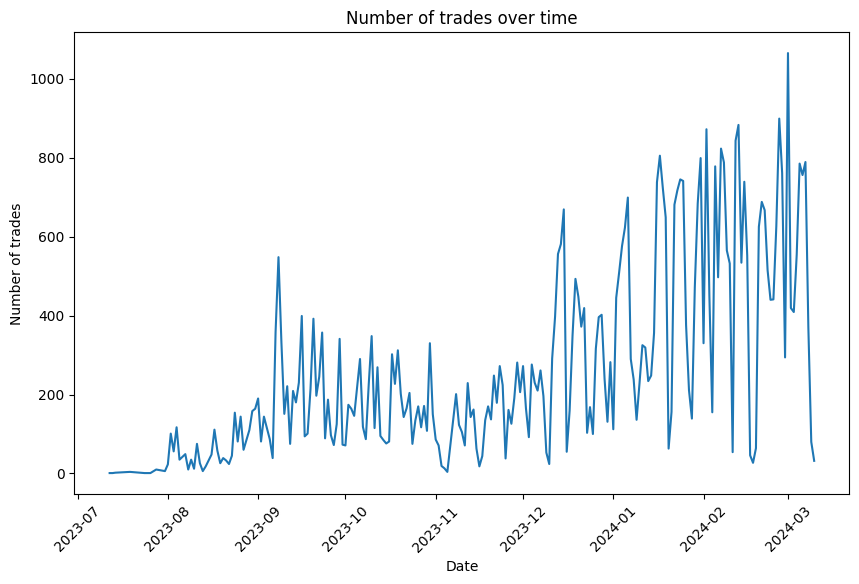

In [117]:
# plot num trades over time
plt.figure(figsize=(10,6))
all_trades['creation_timestamp'].dt.date.value_counts().sort_index().plot(title='Number of trades over time')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Number of trades')

In [119]:
all_trades['creation_timestamp'].min(), all_trades['creation_timestamp'].max()
all_trades['month_year'] = all_trades['creation_timestamp'].dt.to_period('M')
all_trades['month_year_week'] = all_trades['creation_timestamp'].dt.to_period('W')
all_trades['winning_trade'] = all_trades['winning_trade'].astype(int)

In [120]:
all_trades.columns

Index(['trader_address', 'trade_id', 'creation_timestamp', 'title',
       'market_status', 'collateral_amount', 'outcome_index',
       'trade_fee_amount', 'outcomes_tokens_traded', 'current_answer',
       'is_invalid', 'winning_trade', 'earnings', 'redeemed',
       'redeemed_amount', 'num_mech_calls', 'mech_fee_amount', 'net_earnings',
       'roi', 'month_year', 'month_year_week'],
      dtype='object')

In [148]:
all_trades.groupby(['month_year'])['winning_trade'].sum() / all_trades.groupby(['month_year'])['winning_trade'].count()

month_year
2023-07   0.385
2023-08   0.473
2023-09   0.442
2023-10   0.497
2023-11   0.488
2023-12   0.498
2024-01   0.470
2024-02   0.489
2024-03   0.473
Freq: M, Name: winning_trade, dtype: float64

<Axes: title={'center': 'Winning trade percentage over time'}, xlabel='month_year_week'>

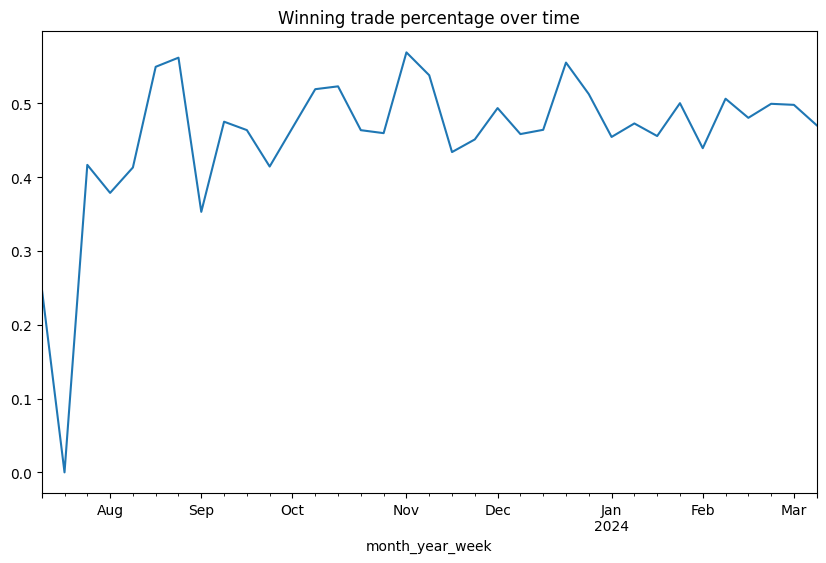

In [121]:
all_trades.groupby('month_year_week')['winning_trade'].mean().plot(title='Winning trade percentage over time', figsize=(10,6))

<Axes: title={'center': 'Mechanical calls over time'}, xlabel='month_year_week'>

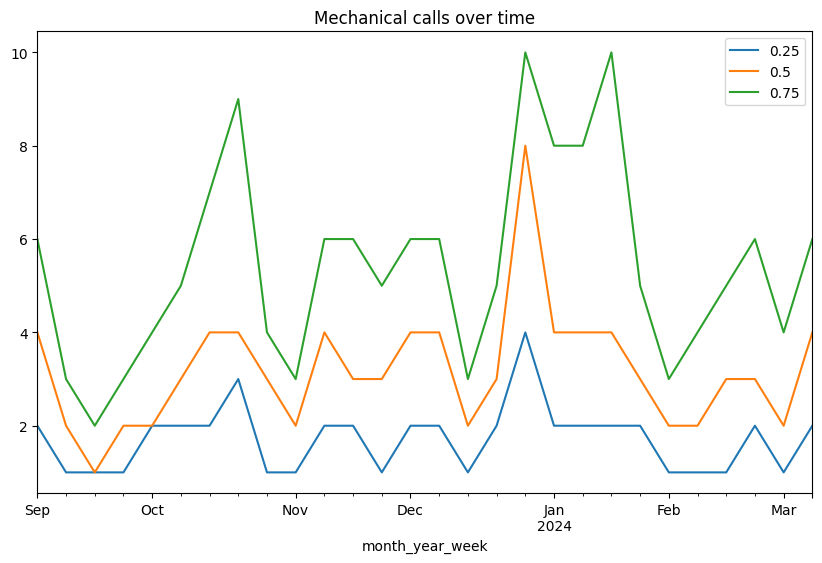

In [136]:
#only plot from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['num_mech_calls'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Mechanical calls over time', figsize=(10,6)) 

<Axes: title={'center': 'Collateral amount quantiles over time'}, xlabel='month_year_week'>

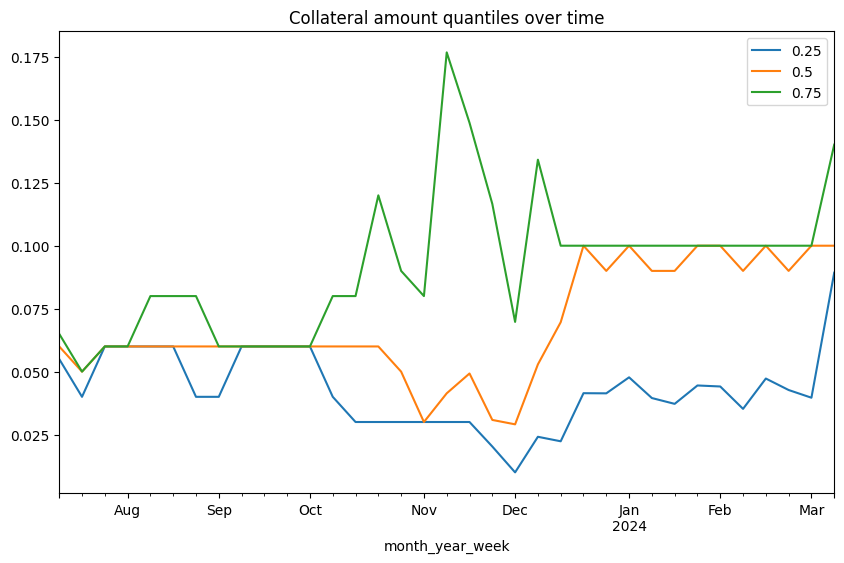

In [131]:
all_trades.groupby('month_year_week')['collateral_amount'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Collateral amount quantiles over time', figsize=(10,6))

<Axes: title={'center': 'Earnings quantiles over time'}, xlabel='month_year_week'>

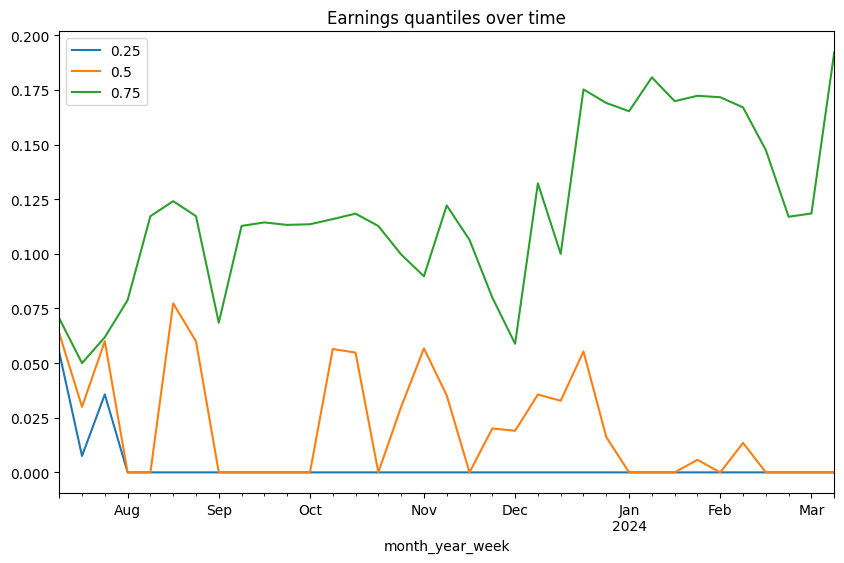

In [132]:
all_trades.groupby('month_year_week')['earnings'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Earnings quantiles over time', figsize=(10,6))

<Axes: title={'center': 'Net earnings quantiles over time'}, xlabel='month_year_week'>

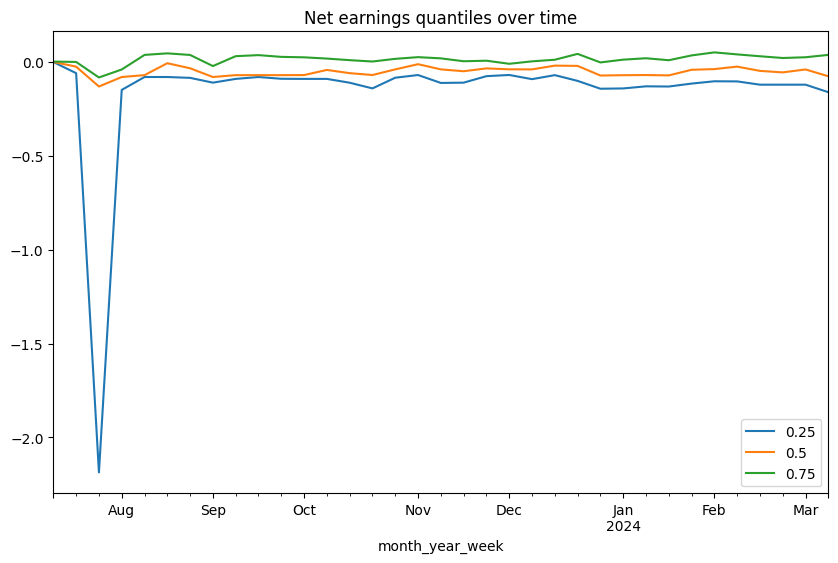

In [137]:
all_trades.groupby('month_year_week')['net_earnings'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Net earnings quantiles over time', figsize=(10,6))

<Axes: title={'center': 'Net earnings quantiles over time'}, xlabel='month_year_week'>

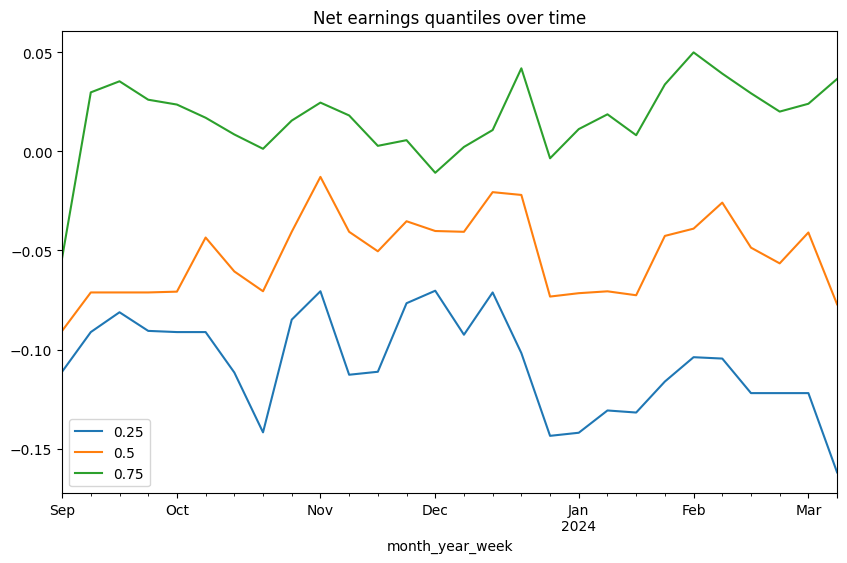

In [138]:
# plot new earnings from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['net_earnings'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Net earnings quantiles over time', figsize=(10,6))

<Axes: title={'center': 'ROI quantiles over time'}, xlabel='month_year_week'>

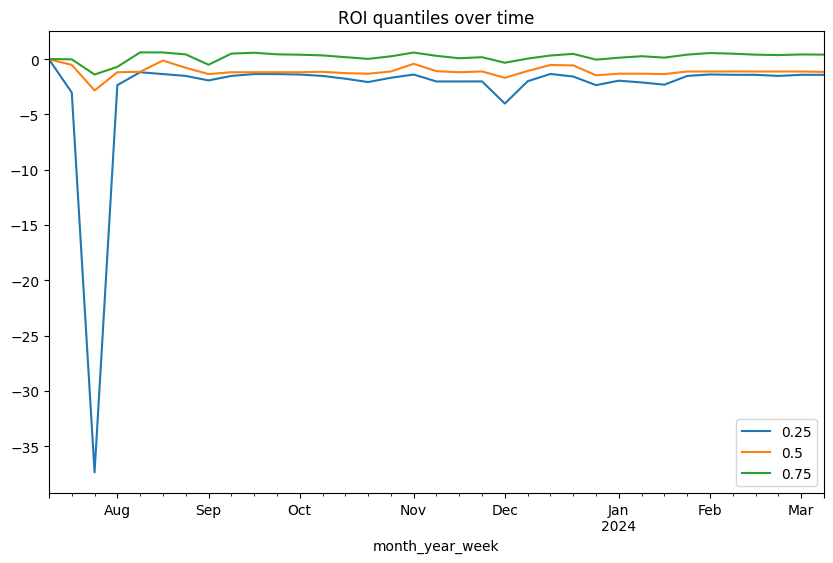

In [139]:
all_trades.groupby('month_year_week')['roi'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='ROI quantiles over time', figsize=(10,6))

<Axes: title={'center': 'ROI quantiles over time'}, xlabel='month_year_week'>

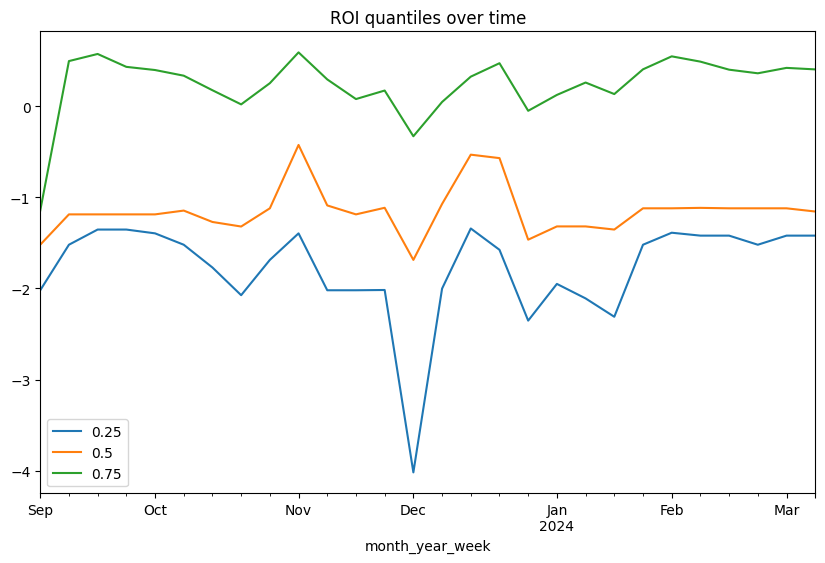

In [140]:
# roi from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['roi'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='ROI quantiles over time', figsize=(10,6))

In [127]:
all_trades['num_mech_calls'].sum()

285452